# Process Webapp Logs

## Load logs

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
logs_path = os.path.join("./webapp/api/log.csv")
logs_df = pd.read_csv(logs_path)

In [46]:
class_map = {"bronx" : 0, "brooklyn": 1,"manhattan": 2, "queens": 3, "staten_island": 4}
inverse_class_map = {0: "Bronx", 1: "Brooklyn", 2: "Manhattan", 3: "Queens", 4: "Staten Island"}

In [3]:
logs_df["y"] = logs_df["label"].apply(lambda label: class_map[label])
logs_df["y_hat"] = logs_df["guess"].apply(lambda label: class_map[label])
logs_df["correct"] = logs_df["y"] == logs_df["y_hat"]

In [4]:
logs_df.head()

,timestamp,user_id,img_id,label,guess,y,y_hat,correct
0,20231124_144500,2988a436-d081-4dcf-b8e3-67e1b60ca931,2246842352113142,queens,queens,3,3,True
1,20231124_144503,2988a436-d081-4dcf-b8e3-67e1b60ca931,419723621199216,bronx,brooklyn,0,1,False
2,20231124_144508,2988a436-d081-4dcf-b8e3-67e1b60ca931,365967006594992,brooklyn,bronx,1,0,False
3,20231124_144513,2988a436-d081-4dcf-b8e3-67e1b60ca931,13824122226053,queens,queens,3,3,True
4,20231124_144520,2988a436-d081-4dcf-b8e3-67e1b60ca931,557202832476989,queens,staten_island,3,4,False


In [5]:
data_path = os.path.join("./data/all/data_webapp.csv")
data_df = pd.read_csv(data_path)

In [6]:
data_df.head()

,id,longitude,latitude,path,url,borough,source
0,391667738085900,-73.993418,40.630333,./data/all/Brooklyn/391667738085900.jpg,https://maps.googleapis.com/maps/api/streetvie...,Brooklyn,Google Maps
1,702979062056016,-73.913657,40.609021,./data/all/Brooklyn/702979062056016.jpg,https://maps.googleapis.com/maps/api/streetvie...,Brooklyn,Google Maps
2,488840315694611,-73.877197,40.893797,./data/all/Bronx/488840315694611.jpg,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Bronx,Mapillary
3,477917698479098,-73.782810,40.753708,./data/all/Queens/477917698479098.jpg,https://maps.googleapis.com/maps/api/streetvie...,Queens,Google Maps
4,851067596596194,-73.988766,40.716325,./data/all/Manhattan/851067596596194.jpg,https://maps.googleapis.com/maps/api/streetvie...,Manhattan,Google Maps


In [7]:
joint_df = logs_df.join(data_df.set_index("id"), on="img_id")

In [8]:
joint_df.head()

,timestamp,user_id,img_id,label,guess,y,y_hat,correct,longitude,latitude,path,url,borough,source
0,20231124_144500,2988a436-d081-4dcf-b8e3-67e1b60ca931,2246842352113142,queens,queens,3,3,True,-73.795231,40.705950,./data/all/Queens/2246842352113142.jpg,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Queens,Mapillary
1,20231124_144503,2988a436-d081-4dcf-b8e3-67e1b60ca931,419723621199216,bronx,brooklyn,0,1,False,-73.907518,40.855807,./data/all/Bronx/419723621199216.jpg,https://maps.googleapis.com/maps/api/streetvie...,Bronx,Google Maps
2,20231124_144508,2988a436-d081-4dcf-b8e3-67e1b60ca931,365967006594992,brooklyn,bronx,1,0,False,-73.937889,40.691131,./data/all/Brooklyn/365967006594992.jpg,https://maps.googleapis.com/maps/api/streetvie...,Brooklyn,Google Maps
3,20231124_144513,2988a436-d081-4dcf-b8e3-67e1b60ca931,13824122226053,queens,queens,3,3,True,-73.871632,40.739891,./data/all/Queens/13824122226053.jpg,https://maps.googleapis.com/maps/api/streetvie...,Queens,Google Maps
4,20231124_144520,2988a436-d081-4dcf-b8e3-67e1b60ca931,557202832476989,queens,staten_island,3,4,False,-73.867128,40.706071,./data/all/Queens/557202832476989.jpg,https://maps.googleapis.com/maps/api/streetvie...,Queens,Google Maps


## Process Logs

### Global stats

In [9]:
correct = joint_df["correct"].to_numpy().astype(float)
accuracy = np.mean(correct)
print(f"Global accuracy: {accuracy * 100:.2f} %")

Global accuracy: 36.04 %


### By Location

In [10]:
from utils.geojson_utils import Neighborhoods
geo_path = os.path.join("./data/location/nyc_boroughs.geojson")
nb = Neighborhoods()
nb.load_geojson(geo_path)

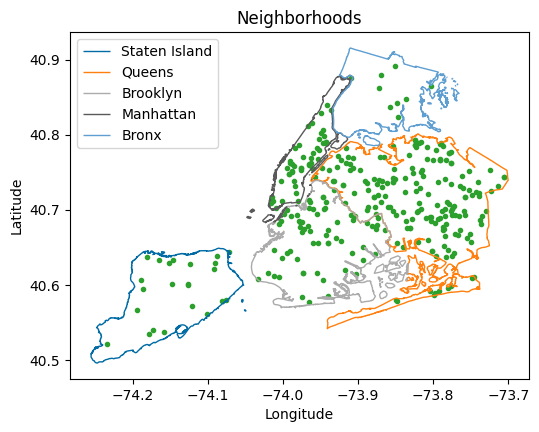

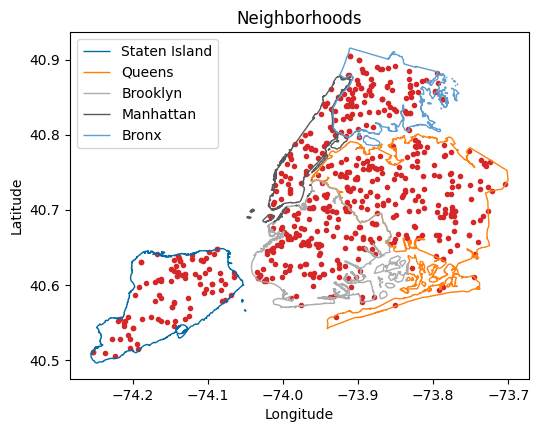

In [76]:
fig_correct, ax_correct = plt.subplots(figsize=(8, 4.5))
fig_wrong, ax_wrong = plt.subplots(figsize=(8, 4.5))

ax_correct = nb.plot(ax=ax_correct)
ax_wrong = nb.plot(ax=ax_wrong)

correct_df = joint_df[joint_df["correct"] == True]
ax_correct.scatter(correct_df["longitude"], correct_df["latitude"], c="tab:green", marker=".")
ax_correct.legend()


wrong_df = joint_df[joint_df["correct"] == False]
ax_wrong.scatter(wrong_df["longitude"], wrong_df["latitude"], c="tab:red", marker=".")
ax_wrong.legend()
plt.show()

### By Borough

In [72]:
# Fraction of correct classifications per borough
n_total = len(joint_df)
for borough in sorted(joint_df["borough"].unique()):
    borough_df = joint_df[joint_df["borough"] == borough]
    n_borough = len(borough_df)
    n_correct = np.count_nonzero(borough_df["correct"])
    print(f"{borough} ({n_borough / n_total * 100:.2f}%): {n_correct}/{n_borough} = {n_correct / n_borough * 100:.2f} %")

Bronx (12.50%): 8/111 = 7.21 %
Brooklyn (24.10%): 66/214 = 30.84 %
Manhattan (11.15%): 48/99 = 48.48 %
Queens (39.19%): 175/348 = 50.29 %
Staten Island (13.06%): 23/116 = 19.83 %


In [73]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y, y_hat, inverse_class_map, normalize=True, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
        
    cm = confusion_matrix(y, y_hat, normalize="true" if normalize else None)
    
    img = ax.imshow(cm, vmin=0., vmax=1. if normalize else None)
    fig.colorbar(img)
    class_names = [inverse_class_map[i] for i in range(len(inverse_class_map))]
    ax.set_xticks([0., 1., 2., 3., 4.])
    ax.set_yticks([0., 1., 2., 3., 4.])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
    return fig, ax 

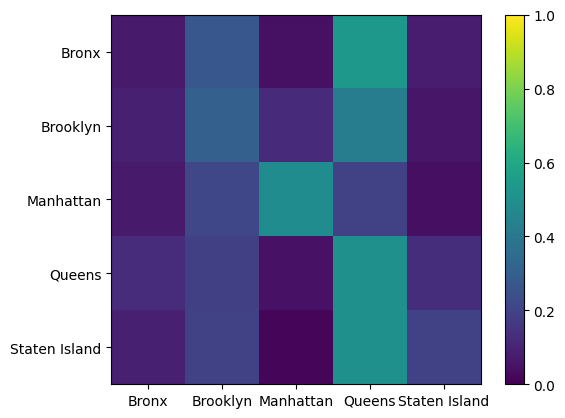

In [74]:
fig, ax = plot_confusion_matrix(joint_df["y"], joint_df["y_hat"], inverse_class_map, normalize=True)
plt.show()

# By user

In [78]:
user_df = joint_df.groupby("user_id")

In [82]:
n_users = len(user_df)
print(f"{n_users = }")

n_users = 18


[260  97  91  88  56  55  50  43  35  25  18  18  14  12  11   7   5   3]


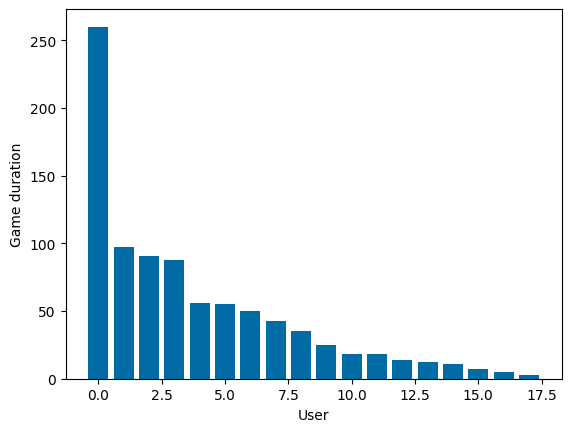

In [117]:
# Guesses per user
n_games_per_user = np.sort(user_df["guess"].count().to_numpy())[::-1]
print(n_games_per_user)
users = np.arange(len(n_games_per_user))
fig, ax = plt.subplots()
ax.bar(users, n_games_per_user)
ax.set_xlabel("User")
ax.set_ylabel("Game duration")
plt.show()

N users with more than 10 guesses = 15
[0.58333333 0.56       0.54545455 0.45454545 0.40659341 0.4
 0.38888889 0.31538462 0.29896907 0.27777778 0.27272727 0.26785714
 0.23255814 0.2        0.14285714]


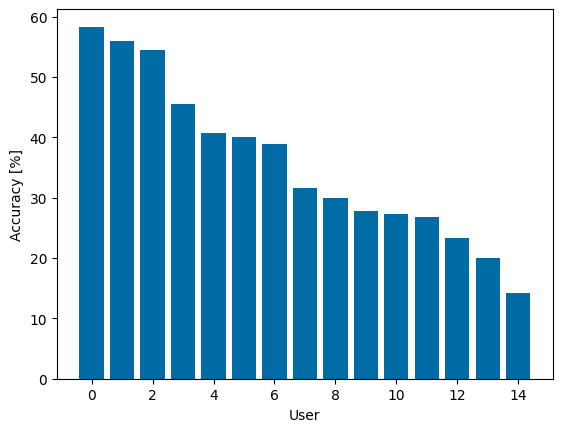

In [120]:
# Accuracy per user
min_guesses = 10
selection = (user_df["guess"].count() > min_guesses).to_numpy() # Only users that took 10 guesses or more
print(f"N users with more than {min_guesses} guesses = {np.count_nonzero(selection)}")
accuracies = np.sort(user_df["correct"].mean().to_numpy()[selection])[::-1]
print(accuracies)
users = np.arange(len(accuracies))
fig, ax = plt.subplots()
ax.bar(users, accuracies * 100)
ax.set_xlabel("User")
ax.set_ylabel("Accuracy [%]")
plt.show()